In [5]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [2]:
diabetes_df = pd.read_csv('diabetes_clean.csv')

In [6]:
diabetes_df.head()

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [15]:
y = diabetes_df["diabetes"].values

In [20]:
X = diabetes_df.drop(["diabetes", "pregnancies", "triceps", "glucose", "diastolic", "insulin", "dpf"], axis=1).values

In [21]:
X

array([[33.6, 50. ],
       [26.6, 31. ],
       [23.3, 32. ],
       ...,
       [26.2, 30. ],
       [30.1, 47. ],
       [30.4, 23. ]])

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, test_size=.3)

In [23]:
X_train.shape

(537, 2)

### Assessing a model

In [24]:
knn = KNeighborsClassifier(n_neighbors=6) # instantiate neighbors classifier

In [25]:
knn.fit(X_train, y_train) # fit the model

KNeighborsClassifier(n_neighbors=6)

In [26]:
y_pred = knn.predict(X_test) # predict labels of test data

In [27]:
# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[117  34]
 [ 47  33]]
              precision    recall  f1-score   support

           0       0.71      0.77      0.74       151
           1       0.49      0.41      0.45        80

    accuracy                           0.65       231
   macro avg       0.60      0.59      0.60       231
weighted avg       0.64      0.65      0.64       231



#### Results

The model produced 117 true positives, 33 true negatives, 34 false negatives, and 47 false positives. The classification report shows a better F1-score for the zero class, which represents individuals who do not have diabetes.

### Logistic regression and the ROC curve

- logistic regression is used for classification problems
- logistic regression produces a linear split
- logitstic regression outputs probabilities
- If probability, $ p > 0.5$:
        - The data is labeled `1`
- If probability, $ p < 0.5$:
        - The data is labeled `0`

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [29]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [32]:
y_pred_probs= logreg.predict_proba(X_test)[:,1]

In [33]:
print(y_pred_probs[:10])

[0.5070309  0.2621656  0.16851245 0.17314983 0.48962511 0.75732791
 0.06118489 0.5155887  0.3488152  0.77754421]


In [36]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

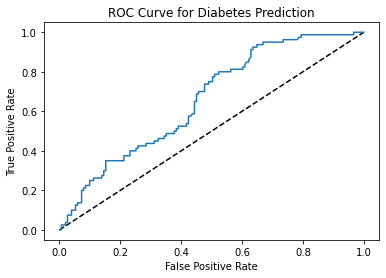

In [37]:
plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Diabetes Prediction')
plt.show()

#### Results

The ROC curve is above the dotted line, so the model performs better than randomly guessing the class of each observation.

**ROC_AUC_SCORE:**
- The area under the ROC curve

In [40]:
print(roc_auc_score(y_test, y_pred_probs))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.6591059602649006
[[117  34]
 [ 47  33]]
              precision    recall  f1-score   support

           0       0.71      0.77      0.74       151
           1       0.49      0.41      0.45        80

    accuracy                           0.65       231
   macro avg       0.60      0.59      0.60       231
weighted avg       0.64      0.65      0.64       231



### Hyperparameters:
- parameters we wpecify before fitting the model
    - such as alpha and n_neighbors
    
#### Hyperparameter Tuning
1. Try different hyperparameter values
2. Fit all of them separately
3. See how well they perform
4. Choose the best performing values

> <span style= "color:indianred">It is **essential** to use cross-validation to avoid overfitting to the test set </span> <br>
> We can still split the data and perform cross-validation on the training set <br>
> We withhold the test set for final evaluation

In [53]:
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.linear_model import Lasso
import numpy as np

In [44]:
param_grid = {"alpha": np.linspace(0.00001,1, 20)}

In [47]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

In [50]:
lasso = Lasso()

In [51]:
lasso_cv = GridSearchCV(lasso, param_grid, cv=kf)

In [52]:
lasso_cv.fit(X_train, y_train)
print("Tuned lasso paramaters: {}".format(lasso_cv.best_params_))
print("Tuned lasso score: {}".format(lasso_cv.best_score_))

Tuned lasso paramaters: {'alpha': 1e-05}
Tuned lasso score: 0.17325351425055815


#### Results

Unfortunately, the best model only has an R-squared score of 0.17, highlighting that using the optimal hyperparameters does not guarantee a high performing model!

In [54]:
#### Randomized Search CV

In [55]:
logreg= LogisticRegression()

In [59]:
# Create the parameter space
params = {"penalty": ["l1", "l2"],
         "tol": np.linspace(0.0001, 1.0, 50),
         "C": np.linspace(0.1, 1.0, 50),
         "class_weight": ["balanced", {0:0.8, 1:0.2}]}

# Instantiate the RandomizedSearchCV object
logreg_cv = RandomizedSearchCV(logreg, params, cv=kf)

# Fit the data to the model
logreg_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Best Accuracy Score: {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'tol': 0.8775632653061224, 'penalty': 'l2', 'class_weight': 'balanced', 'C': 0.9816326530612246}
Tuned Logistic Regression Best Accuracy Score: 0.7019383869851159


/Users/kevinkwasnik/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/kevinkwasnik/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/kevinkwasnik/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/kevinkwasnik/opt/anaconda3/lib/python3.9/site-packages/sklearn/linea

#### Results

Even without exhaustively trying every combination of hyperparameters, the model has an accuracy of over 70% on the test set! So far we have worked with clean datasets; however, in the next chapter, we will discuss the steps required to transform messy data before building supervised learning models.